#Import libraries

In [1]:
# Standard libraries
import math
import time
import random
from typing import List, Tuple

# Numerical and GPU computation libraries
import numpy as np
from numba import cuda, jit, prange, float32

# Image processing libraries
import cv2
from PIL import Image

# Plotting libraries
import matplotlib.pyplot as plt

# Machine learning and dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


#Kernel definitions

In [2]:
class KMeans:
    def __init__(self, n_clusters: int = 3, max_iter: int = 100, random_state: int = None):
        """
        Initialize K-Means Clustering

        Parameters:
        - n_clusters: Number of clusters
        - max_iter: Maximum iterations
        - random_state: Seed for reproducibility
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

        # Attributes to be set during fitting
        self.centroids = None
        self.labels = None

    def _euclidean_distance(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """
        Calculate Euclidean distance between two points

        Parameters:
        - x1: First point
        - x2: Second point

        Returns:
        - Euclidean distance
        """

        return np.sqrt(np.sum((x1 - x2) ** 2))

    def fit(self, X: np.ndarray) -> 'KMeans':
        """
        Fit the K-Means algorithm

        Parameters:
        - X: Input data array

        Returns:
        - Self
        """

        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Randomly initialize centroids
        random_idx = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_idx]


        for _ in range(self.max_iter):
            # Calculate distances between each point and each centroid (vectorized)
            distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids) ** 2).sum(axis=2))
            # Assign each point to the nearest centroid
            self.labels = np.argmin(distances, axis=1)

            # Calculate new centroids as the mean of each cluster
            new_centroids = np.array([X[self.labels == i].mean(axis=0) if len(X[self.labels == i]) > 0
                                      else self.centroids[i] for i in range(self.n_clusters)])

            # Check for convergence
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict cluster labels for new data

        Parameters:
        - X: Input data array

        Returns:
        - Cluster labels
        """

        distances = np.sqrt(((X[:, np.newaxis, :] - self.centroids) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)

    def get_wcss(self, X: np.ndarray) -> float:
        """
        Calculate Within-Cluster Sum of Squares

        Parameters:
        - X: Input data array

        Returns:
        - WCSS value
        """

        wcss = 0
        for i in range(self.n_clusters):
            cluster_points = X[self.labels == i]
            wcss += np.sum((cluster_points - self.centroids[i]) ** 2)
        return wcss

In [3]:
class FuzzyCMeans:
    def __init__(self, n_clusters: int = 3, max_iter: int = 100,
                 m: float = 2.0, epsilon: float = 1e-4):
        """
        Initialize Fuzzy C-Means Clustering

        Parameters:
        - n_clusters: Number of clusters
        - max_iter: Maximum iterations
        - m: Fuzzy coefficient (default 2)
        - epsilon: Convergence threshold
        """

        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m  # Fuzzy coefficient (should be > 1)
        self.epsilon = epsilon

        # Attributes to be set during fitting
        self.centroids = None
        self.membership_matrix = None

    def _euclidean_distance(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """Calculate Euclidean distance"""

        return np.sqrt(np.sum((x1 - x2) ** 2))

    def fit(self, X: np.ndarray) -> 'FuzzyCMeans':
        """
        Fit the Fuzzy C-Means algorithm

        Parameters:
        - X: Input data array

        Returns:
        - Self
        """

        n_samples, n_features = X.shape

        # Initialize random membership matrix
        self.membership_matrix = np.random.dirichlet(np.ones(self.n_clusters), size=n_samples)

        for _ in range(self.max_iter):
            # Store previous centroids
            prev_centroids = self.centroids.copy() if self.centroids is not None else None

            # Calculate centroids
            self.centroids = self._calculate_centroids(X)

            # Update membership matrix
            self._update_membership_matrix(X)

            # Check convergence
            if (prev_centroids is not None and
                np.allclose(self.centroids, prev_centroids, atol=self.epsilon)):
                break

        return self

    def _calculate_centroids(self, X: np.ndarray) -> np.ndarray:
        """
        Calculate cluster centroids based on the current membership matrix

        Parameters:
        - X: Input data array

        Returns:
        - Centroids array
        """

        # Calculate centroids as the weighted mean of all samples in the cluster
        weights = self.membership_matrix ** self.m
        centroids = (weights.T @ X) / weights.sum(axis=0)[:, np.newaxis]
        return centroids

    def _update_membership_matrix(self, X: np.ndarray):
        """
        Update membership matrix with vectorized calculation

        Parameters:
        - X: Input data array
        """

        # Compute distances from each point to each centroid
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids, axis=2)

        # Avoid division by zero by setting small values to a minimum
        distances = np.maximum(distances, 1e-10)

        # Update membership matrix with broadcasting
        power = 2 / (self.m - 1)
        inv_distances = 1.0 / distances
        self.membership_matrix = inv_distances ** power / np.sum(inv_distances ** power, axis=1, keepdims=True)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict hard cluster labels based on the highest membership values

        Parameters:
        - X: Input data array

        Returns:
        - Cluster labels
        """

        return np.argmax(self.membership_matrix, axis=1)

#Behaviors

In [8]:
class ImageClustering:
    def __init__(self, clustering_method, n_clusters=10):
        """
        Initialize Image Clustering

        Parameters:
        - clustering_method: KMeans or FuzzyCMeans class
        - n_clusters: Number of colors to reduce to
        """
        self.clustering_method = clustering_method
        self.n_clusters = n_clusters
        self.clusterer = None

    def load_image(self, image_path):
        """
        Load and preprocess image

        Parameters:
        - image_path: Path to the image file

        Returns:
        - Original image array
        - Flattened image data
        """
        try:
            # Open the image
            image = Image.open(image_path)

            # Convert to numpy array
            image_array = np.array(image)

            # Reshape image to 2D array of pixels
            pixels = image_array.reshape((-1, 3))

            return image_array, pixels

        except Exception as e:
            raise IOError(f"Error loading image: {e}")

    def quantize_image(self, image_path):
        """
        Perform color quantization

        Parameters:
        - image_path: Path to the image file

        Returns:
        - Original image
        - Quantized image
        - Centroids (for cluster colors)
        - Labels (cluster assignments for each pixel)
        """

        # Load image
        original_image, pixels = self.load_image(image_path)

        # Start timing
        start_time = time.perf_counter()  # better

        # Perform clustering
        self.clusterer = self.clustering_method(n_clusters=self.n_clusters)
        self.clusterer.fit(pixels)

        # Get cluster centroids and labels for each pixel
        centroids = self.clusterer.centroids
        labels = self.clusterer.predict(pixels)

        # Reconstruct image using cluster centroids
        quantized_pixels = centroids[labels].astype('uint8')

        # Reshape back to original image shape
        quantized_image = quantized_pixels.reshape(original_image.shape)

        # End timing
        end_time = time.perf_counter()  # better

        print(f"Clustering Time: {end_time - start_time:.4f} seconds")

        return original_image, quantized_image, centroids, labels, pixels

    def visualize_results(self, original_image, quantized_image):
        """
        Visualize original and quantized images

        Parameters:
        - original_image: Original image array
        - quantized_image: Quantized image array
        """
        # Create figure with two subplots
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(original_image)
        plt.axis('off')

        # Quantized Image
        plt.subplot(1, 2, 2)
        plt.title(f'Quantized Image ({self.n_clusters} Colors)')
        plt.imshow(quantized_image)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_clusters(self, pixels, labels, centroids, method='pca'):
        """
        Visualize clusters in 2D space using PCA or t-SNE

        Parameters:
        - pixels: Original pixel data (flattened image)
        - labels: Cluster labels for each pixel
        - centroids: Centroid colors for each cluster
        - method: Dimensionality reduction method ('pca' or 'tsne')
        """
        # Reduce dimensions
        plt.figure(figsize=(8, 6))

        # Plot each cluster with its centroid color
        for i, color in enumerate(centroids):
            cluster_pixels = pixels[labels == i]

            # Using RGB color components for 2D plotting
            plt.scatter(cluster_pixels[:, 0], cluster_pixels[:, 1],
                        color=np.clip(color / 255, 0, 1),  # Normalize to [0,1] for matplotlib
                        label=f'Cluster {i}', s=10, alpha=0.6)

        # Mark the centroids in black
        plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')

        plt.title("Cluster Visualization with Exact Colors")
        plt.xlabel("Red channel")
        plt.ylabel("Green channel")
        plt.legend()
        plt.show()

    def save_quantized_image(self, quantized_image, output_path):
        """
        Save quantized image

        Parameters:
        - quantized_image: Quantized image array
        - output_path: Path to save the image
        """
        Image.fromarray(quantized_image).save(output_path)

#TEST

Clustering Time: 25.2872 seconds


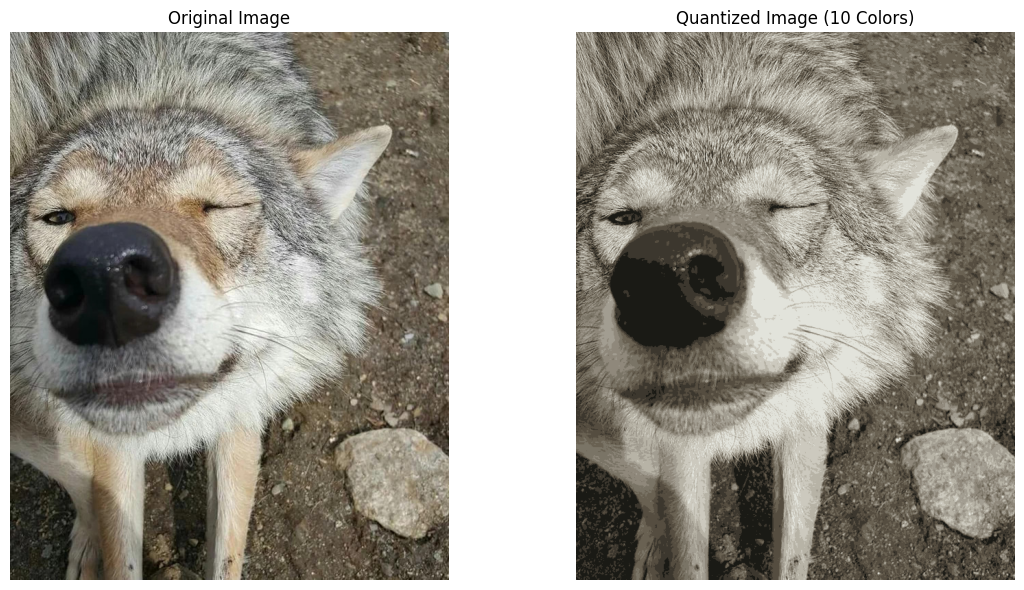

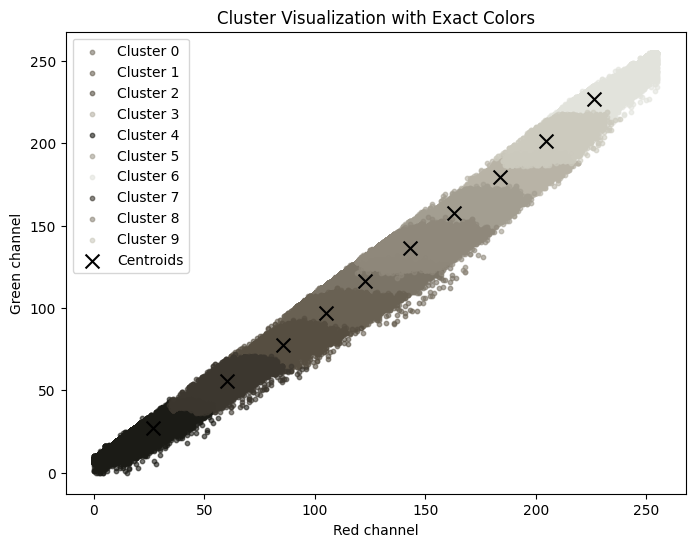

In [9]:
def main():
    # Image path
    image_path = '/content/wolf1.jpg'

    # Create image clustering instance
    image_clusterer = ImageClustering(
        clustering_method=KMeans,   # Choose KMeans or FuzzyCMeans
        n_clusters=10               # Number of colors
    )

    try:
        # Perform color quantization
        original, quantized, centroids, labels, pixels = image_clusterer.quantize_image(image_path)

        # Visualize results
        image_clusterer.visualize_results(original, quantized)

        # Visualize cluster colors in 2D space
        image_clusterer.visualize_clusters(pixels, labels, centroids, method='pca')

        # Optionally save quantized image
        image_clusterer.save_quantized_image(
            quantized,
            '/content/quantized_image.jpg'
        )


    except Exception as e:
        print(f"An error occurred: {e}")

# Run the main function
if __name__ == "__main__":
    main()